<a href="https://colab.research.google.com/github/Dyakonov/python_hacks/blob/master/dj_dl_cnn01_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Свёрточная сеть: MNIST

Александр Дьяконов, 2020

#### Использованы материалы:
* https://atcold.github.io/pytorch-Deep-Learning/

In [1]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
device

device(type='cuda', index=0)

## Датасет

In [3]:
input_size  = 28*28   # размер изображения
output_size = 10      # 10 классов

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 11771722.60it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 353834.79it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3269747.22it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3175617.40it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



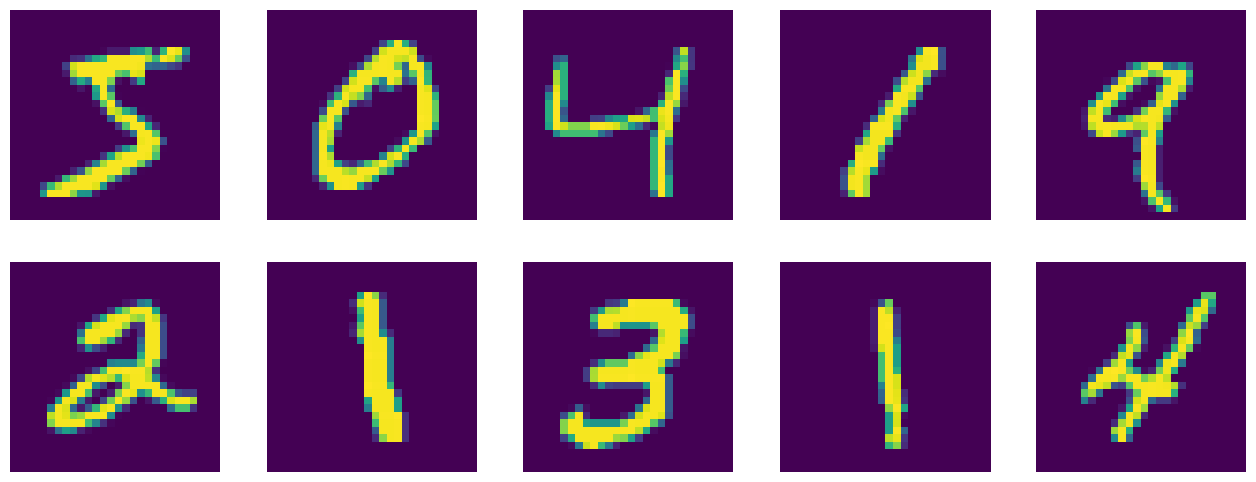

In [4]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [5]:
train_loader.dataset.__getitem__(0)[0].squeeze()[15:20, 15:20]

tensor([[ 1.9432,  2.7960,  2.7960,  1.4850, -0.0806],
        [-0.2206,  0.7595,  2.7833,  2.7960,  1.9560],
        [-0.4242, -0.4242,  2.7451,  2.7960,  2.7451],
        [ 1.2305,  1.9051,  2.7960,  2.7960,  2.2105],
        [ 2.7960,  2.7960,  2.7960,  2.7578,  1.8923]])

# Нейросеть

In [6]:
class Mlinear(nn.Module):
    """
    линейная
    """
    def __init__(self, input_size, output_size):
        super(Mlinear, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=28)
        # self.fc = nn.Linear(28*28, output_size)

    def forward(self, x, verbose=False):
        x = self.conv(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

In [10]:
def get_n_params(model):
    """
    число параметров
    """
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In [7]:
accuracy_list = []

def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [12]:

model = Mlinear(input_size, output_size)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model)))

for epoch in range(0, 3):
    train(epoch, model)
    test(model)
# Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.122960
#Test set: Average loss: 0.4662, Accuracy: 8823/10000 (88%)

Number of parameters: 7850
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.603585
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.408347
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.274262
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.377448
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.340913
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.193120
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.337925
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.660510
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.291437
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.206822

Test set: Average loss: 0.3076, Accuracy: 9140/10000 (91%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.256693
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.145620
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.231328
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.346040
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.318065
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.436309
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.240021
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.185294
Train Epoch: 1 [51200/60

## визуализируем параметры

In [13]:
# параметры модели
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

conv.weight tensor([[[[-0.0286, -0.0058, -0.0249,  ...,  0.0378, -0.0037, -0.0225],
          [-0.0272, -0.0122, -0.0059,  ...,  0.0353, -0.0214,  0.0318],
          [-0.0019, -0.0094,  0.0155,  ...,  0.0291,  0.0387, -0.0302],
          ...,
          [ 0.0092,  0.0265, -0.0280,  ..., -0.0263, -0.0282, -0.0182],
          [ 0.0357, -0.0037,  0.0004,  ...,  0.0040, -0.0264,  0.0320],
          [ 0.0101, -0.0313, -0.0136,  ...,  0.0342,  0.0158,  0.0395]]],


        [[[-0.0182, -0.0231,  0.0373,  ...,  0.0056,  0.0243,  0.0134],
          [-0.0031,  0.0046,  0.0194,  ...,  0.0153, -0.0015, -0.0115],
          [-0.0171,  0.0111,  0.0028,  ..., -0.0190, -0.0069,  0.0065],
          ...,
          [ 0.0010,  0.0321,  0.0228,  ...,  0.0021, -0.0099, -0.0134],
          [ 0.0451,  0.0442, -0.0164,  ...,  0.0409,  0.0151,  0.0044],
          [-0.0058,  0.0209,  0.0444,  ...,  0.0124, -0.0144,  0.0431]]],


        [[[ 0.0168, -0.0074, -0.0275,  ..., -0.0259, -0.0430,  0.0256],
          [ 0.

In [14]:
param.data

tensor([ 0.0193, -0.0128,  0.0220,  0.0220, -0.0042,  0.0742, -0.0282,  0.0284,
        -0.0327, -0.0238], device='cuda:0')

In [15]:
h = list(model.named_parameters())[0][1][2].detach().to('cpu').numpy()[0,:,:]

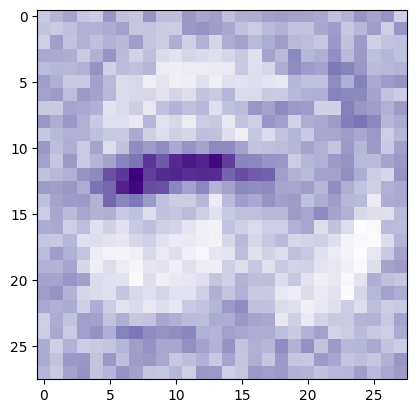

In [16]:
plt.imshow(h, cmap='Purples_r')

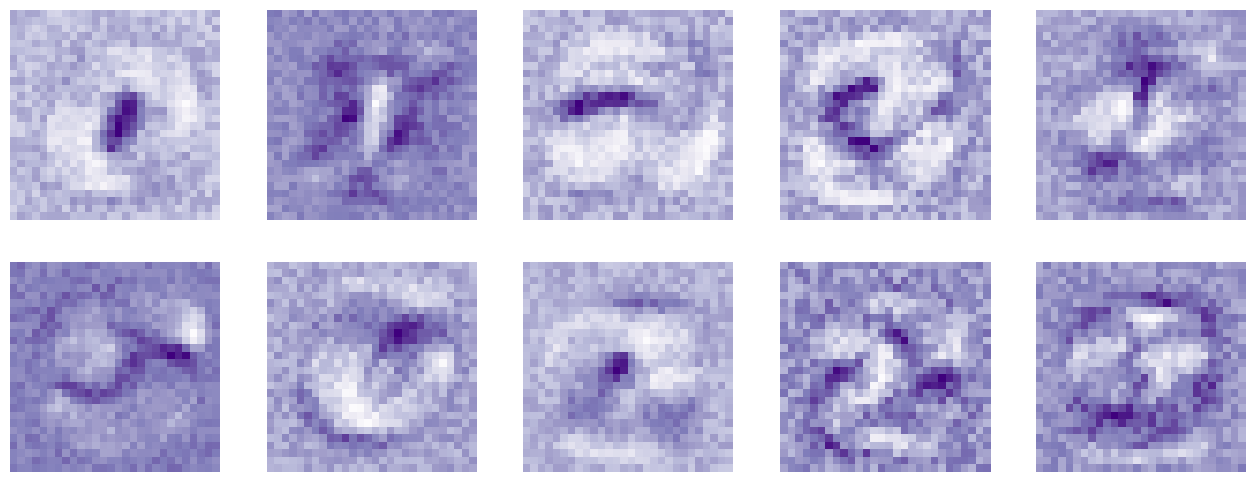

In [17]:
# выученные патерны классов
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = list(model.named_parameters())[0][1][i].detach().to('cpu').numpy()[0,:,:]
    plt.imshow(image, cmap='Purples_r')
    plt.axis('off');

## Сложная модель

In [18]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4) # torch.flatten(x, 1 или 2)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [19]:
# Training settings
n_features = 10 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 3):
    train(epoch, model_cnn)
    test(model_cnn)

# Test set: Average loss: 0.2849, Accuracy: 9203/10000 (92%)
# Test set: Average loss: 0.1034, Accuracy: 9679/10000 (97%)
# Test set: Average loss: 0.0784, Accuracy: 9753/10000 (98%)

Number of parameters: 11330
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.296339
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.816613
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.383777
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.478261
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.358241
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.167692
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.104303
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.131927
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.335986
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.127065

Test set: Average loss: 0.1328, Accuracy: 9602/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.148493
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.046618
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.087262
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.143547
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.156700
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.189644
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.090509
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.032762
Train Epoch: 1 [51200/6

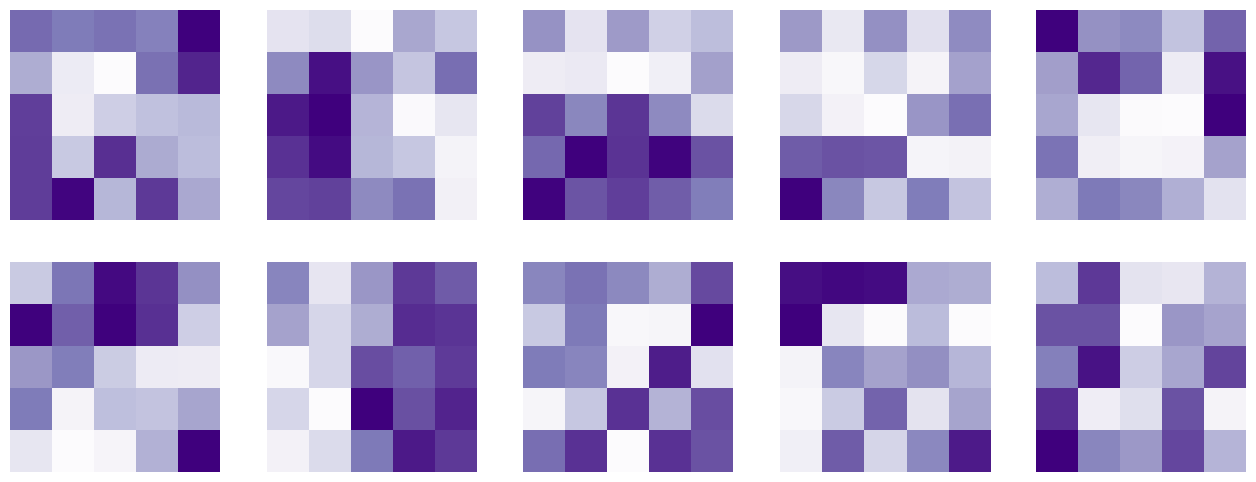

In [20]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = list(model_cnn.named_parameters())[0][1][i].detach().to('cpu').numpy()[0,:,:]
    plt.imshow(image, cmap='Purples_r')
    plt.axis('off');

### Дополнение: как меняют размеры тензоры

In [21]:
f = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
x = torch.randn(1, 1, 28, 28)
print (x.shape)
x = f(x)
print (x.shape)
x = F.max_pool2d(x, kernel_size=2)
print (x.shape)
x = f(x)
print (x.shape)
x = F.max_pool2d(x, kernel_size=2)
print (x.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 26, 26])
torch.Size([1, 1, 13, 13])
torch.Size([1, 1, 11, 11])
torch.Size([1, 1, 5, 5])


## Сложная модель, свёртки 3x3

In [22]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=3)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=3)
        self.fc1 = nn.Linear(n_feature*5*5, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*5*5)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [23]:
# Training settings
n_features = 10 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 3):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 14070
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316544
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.374776
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.438161
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.359085
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.302965
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.324319
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.479134
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.138521
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.186774
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.103979

Test set: Average loss: 0.1715, Accuracy: 9495/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.217417
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.110961
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.209637
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.305281
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.076961
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.166488
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.118554
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.093350
Train Epoch: 1 [51200/6

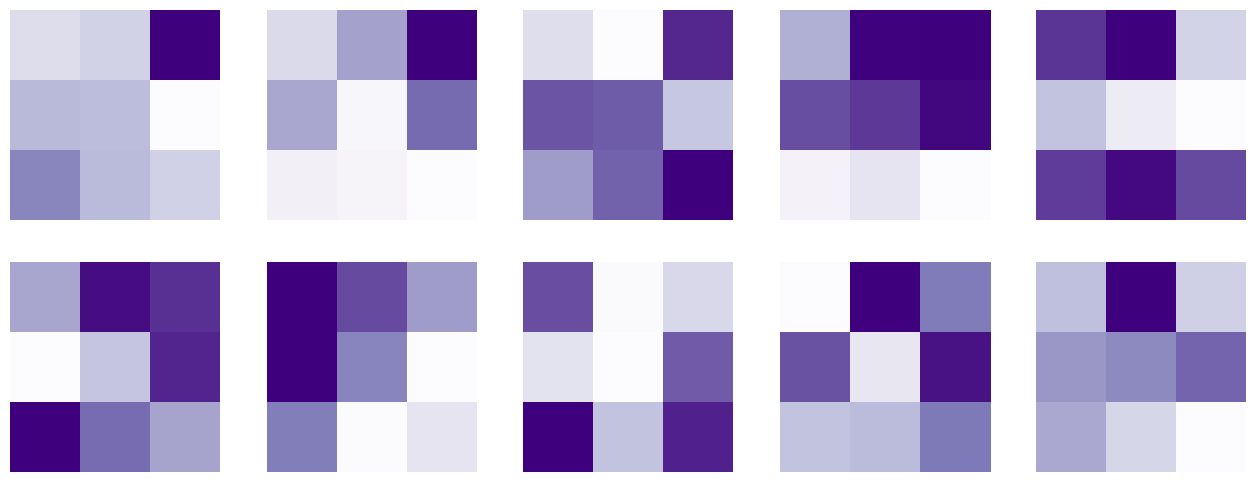

In [24]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image = list(model_cnn.named_parameters())[0][1][i].detach().to('cpu').numpy()[0,:,:]
    plt.imshow(image, cmap='Purples_r')
    plt.axis('off');

In [25]:
from torchsummary import summary
summary(model_cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
            Conv2d-2           [-1, 10, 11, 11]             910
            Linear-3                   [-1, 50]          12,550
            Linear-4                   [-1, 10]             510
Total params: 14,070
Trainable params: 14,070
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.05
Estimated Total Size (MB): 0.12
----------------------------------------------------------------


In [26]:
for name, param in model_cnn.named_parameters():
    if param.requires_grad:
        print (name, param.data)

conv1.weight tensor([[[[ 0.2637,  0.2215, -0.3514],
          [ 0.1389,  0.1490,  0.4465],
          [-0.0182,  0.1432,  0.2137]]],


        [[[ 0.3453,  0.1802, -0.2022],
          [ 0.1966,  0.4955,  0.0322],
          [ 0.4550,  0.4847,  0.5259]]],


        [[[ 0.2720,  0.4347, -0.1960],
          [-0.0986, -0.0824,  0.1970],
          [ 0.0801, -0.0703, -0.2865]]],


        [[[ 0.1669, -0.3237, -0.3304],
          [-0.1213, -0.1786, -0.3119],
          [ 0.4657,  0.3754,  0.5301]]],


        [[[ 0.0417, -0.1041,  0.5103],
          [ 0.4525,  0.6356,  0.7506],
          [ 0.0583, -0.0749,  0.0940]]],


        [[[ 0.0021, -0.3009, -0.2369],
          [ 0.2758,  0.0729, -0.2548],
          [-0.3270, -0.1292, -0.0032]]],


        [[[-0.3147, -0.1328,  0.0855],
          [-0.3135,  0.0107,  0.4725],
          [-0.0160,  0.4647,  0.3289]]],


        [[[-0.1146,  0.4070,  0.2387],
          [ 0.2784,  0.4162, -0.0873],
          [-0.2810,  0.1719, -0.2066]]],


        [[[ 0.4076,

# Автокодировщик

In [27]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 10),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [28]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [29]:
learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epoch [1/20], loss:0.5860
epoch [2/20], loss:0.5185
epoch [3/20], loss:0.5245
epoch [4/20], loss:0.5293
epoch [5/20], loss:0.5151
epoch [6/20], loss:0.5035
epoch [7/20], loss:0.4863
epoch [8/20], loss:0.4753
epoch [9/20], loss:0.4744
epoch [10/20], loss:0.5202
epoch [11/20], loss:0.4398
epoch [12/20], loss:0.4983
epoch [13/20], loss:0.5266
epoch [14/20], loss:0.4829
epoch [15/20], loss:0.5138
epoch [16/20], loss:0.4890
epoch [17/20], loss:0.5015
epoch [18/20], loss:0.4741
epoch [19/20], loss:0.4488
epoch [20/20], loss:0.4470


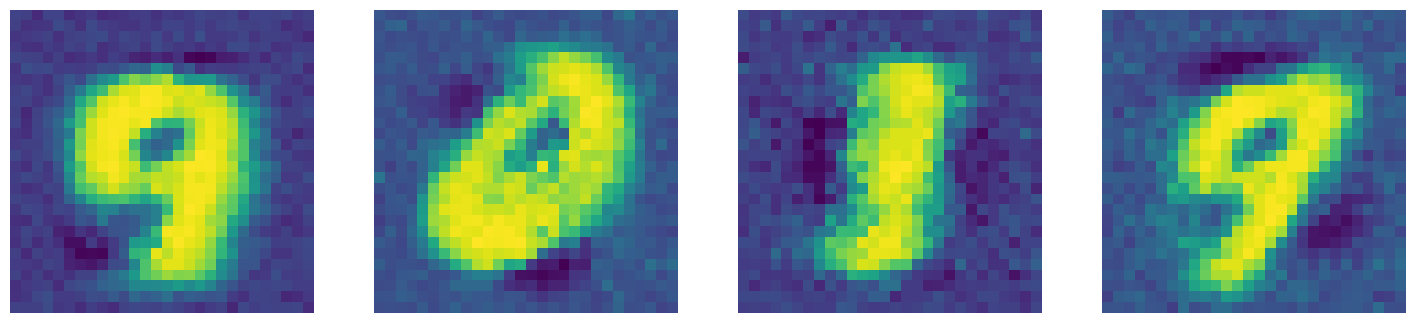

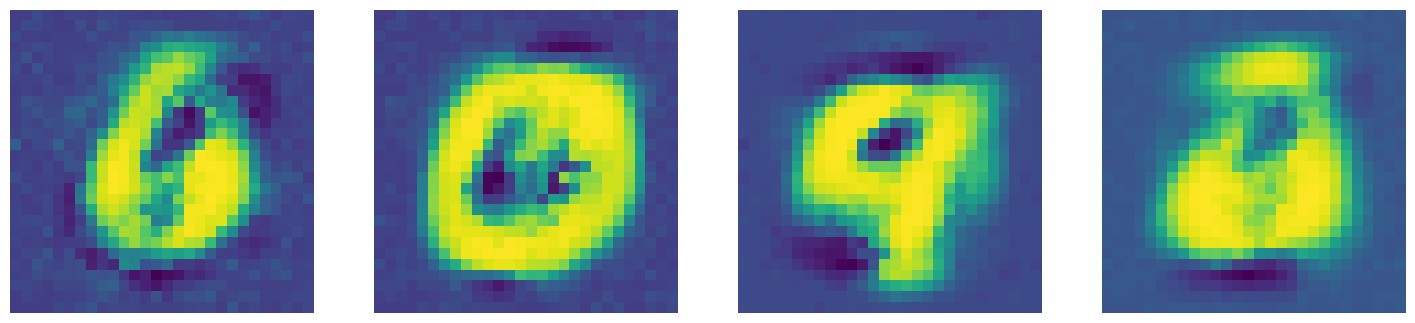

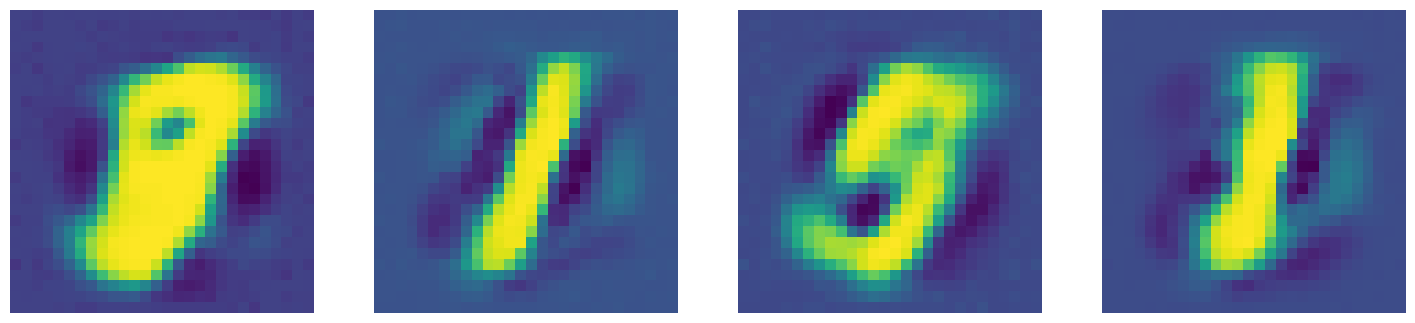

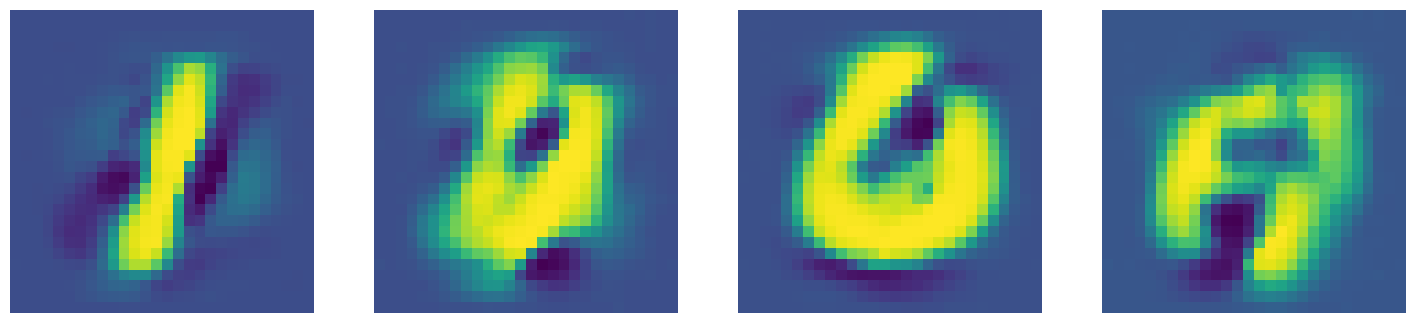

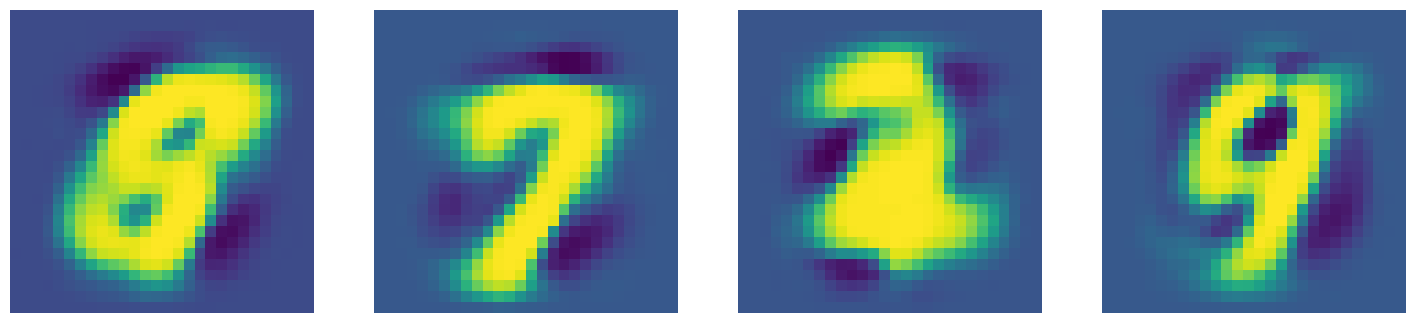

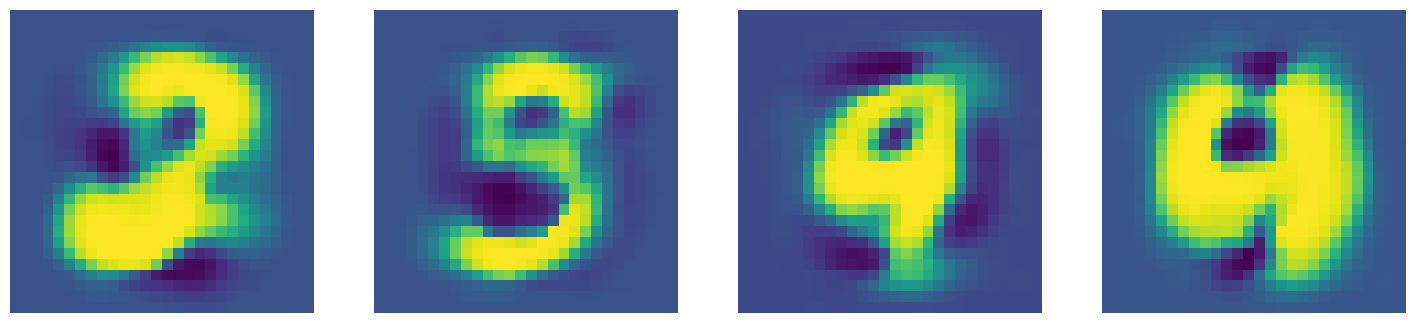

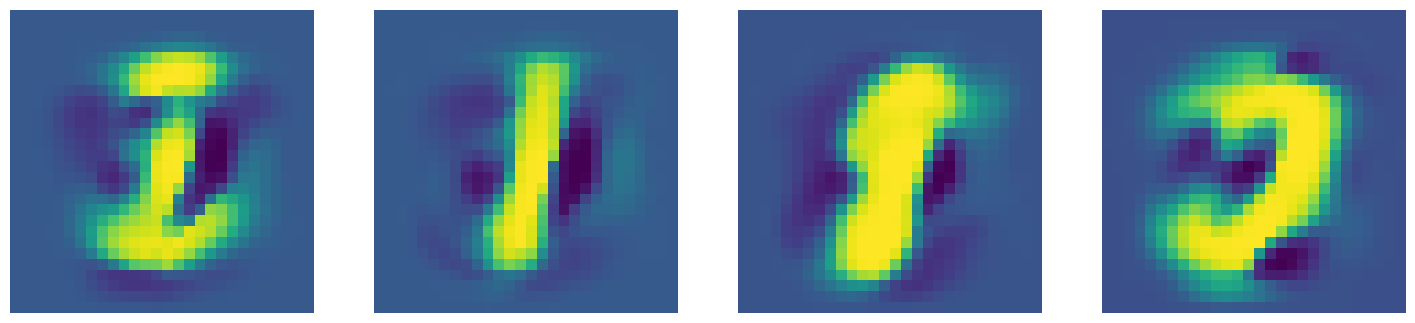

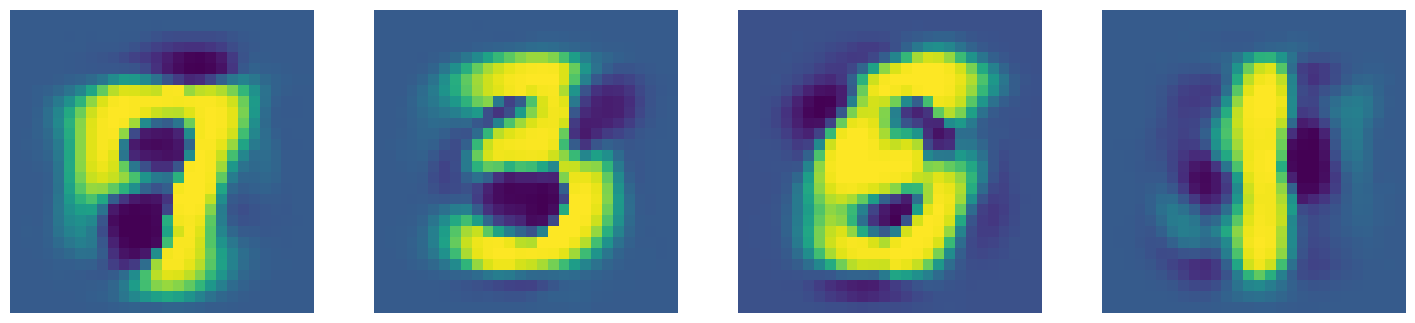

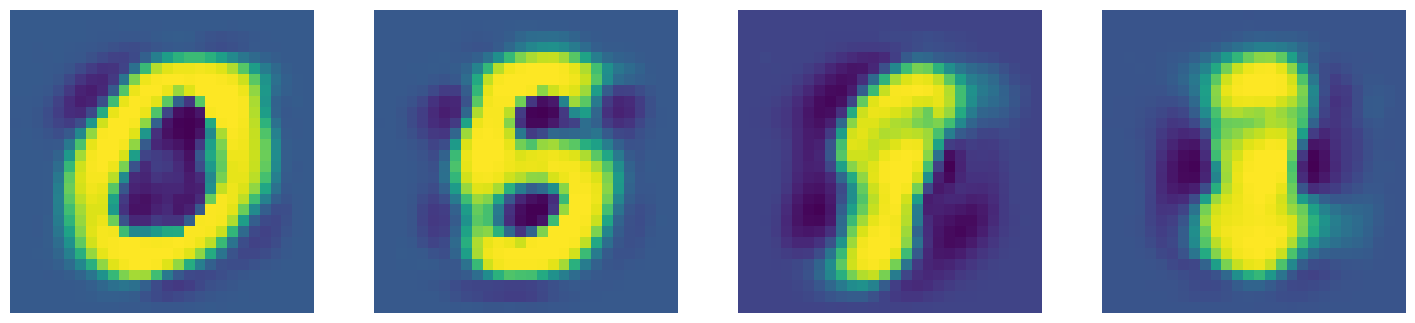

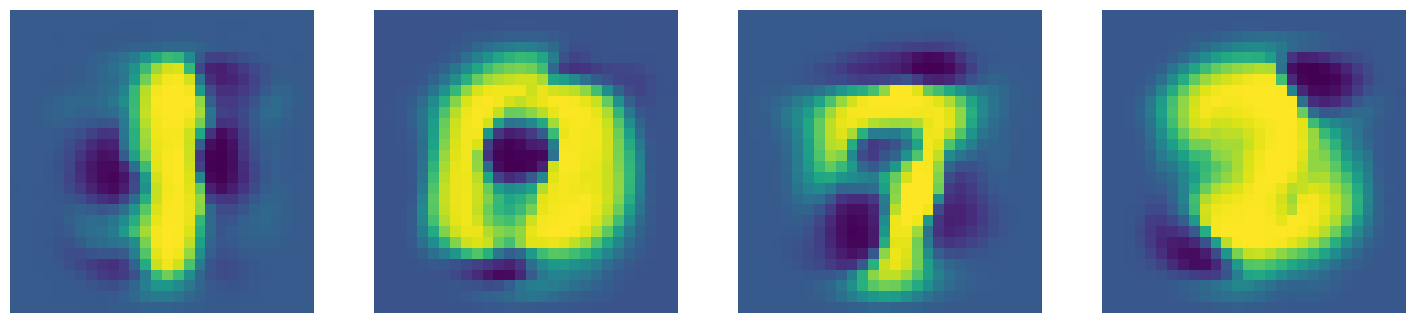

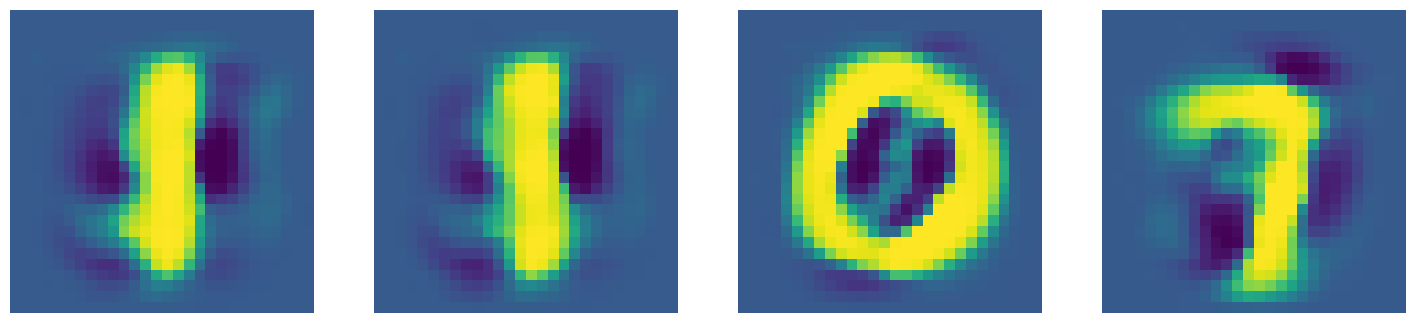

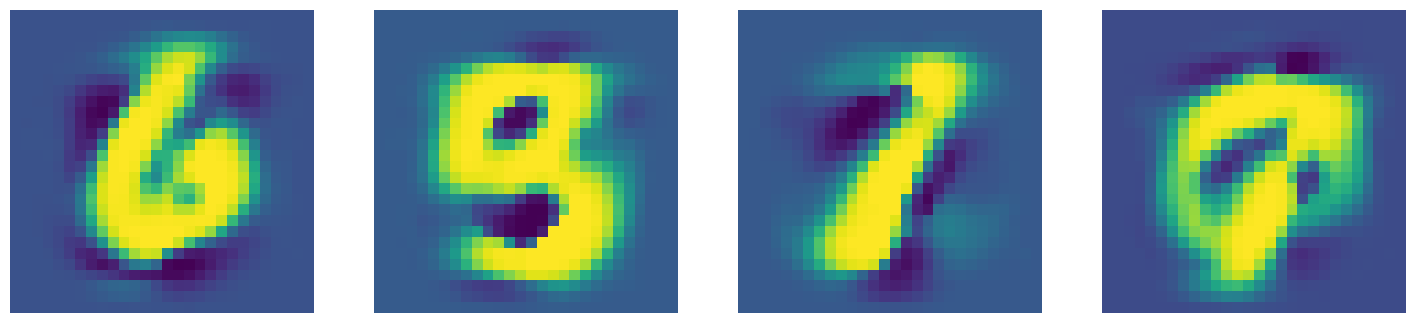

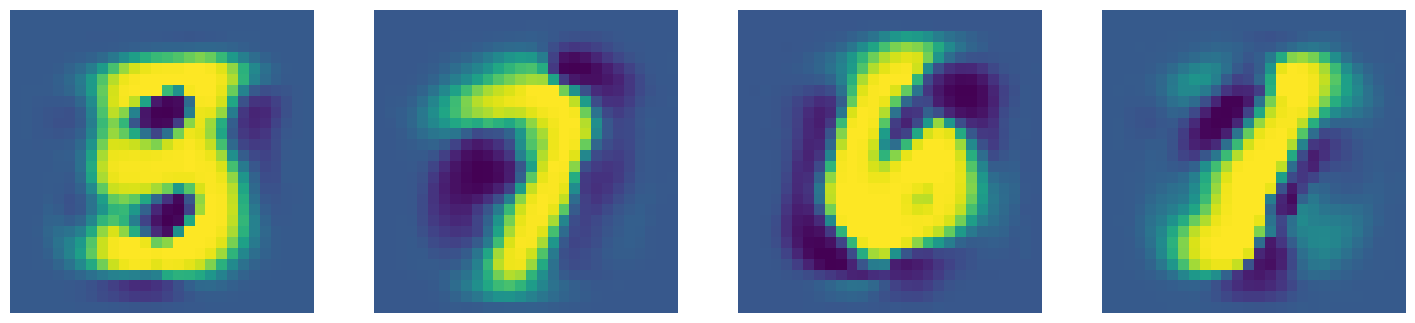

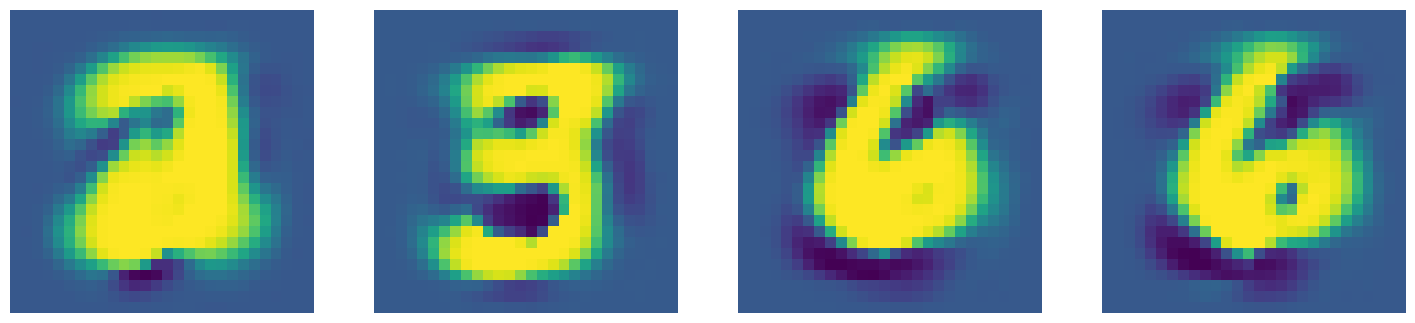

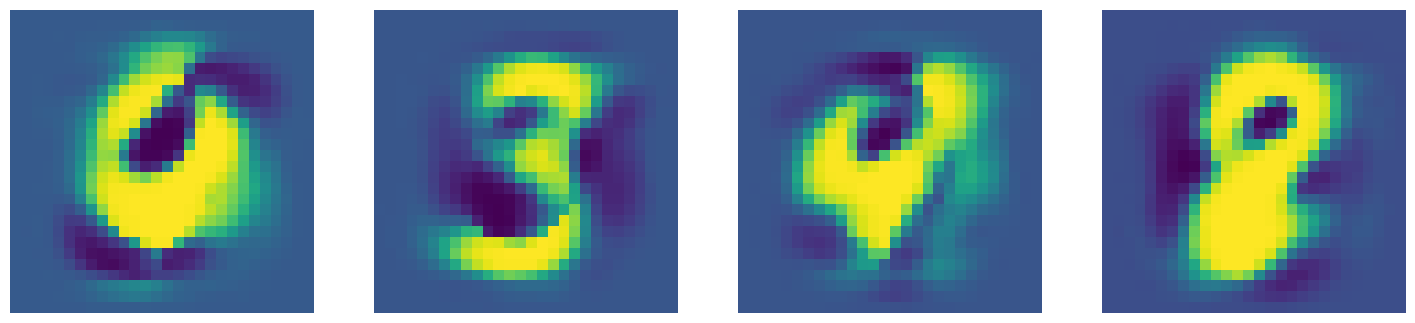

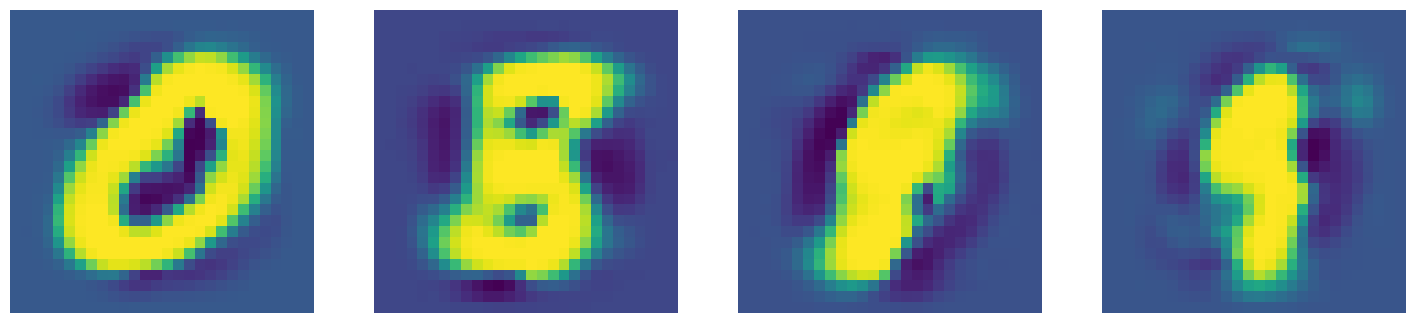

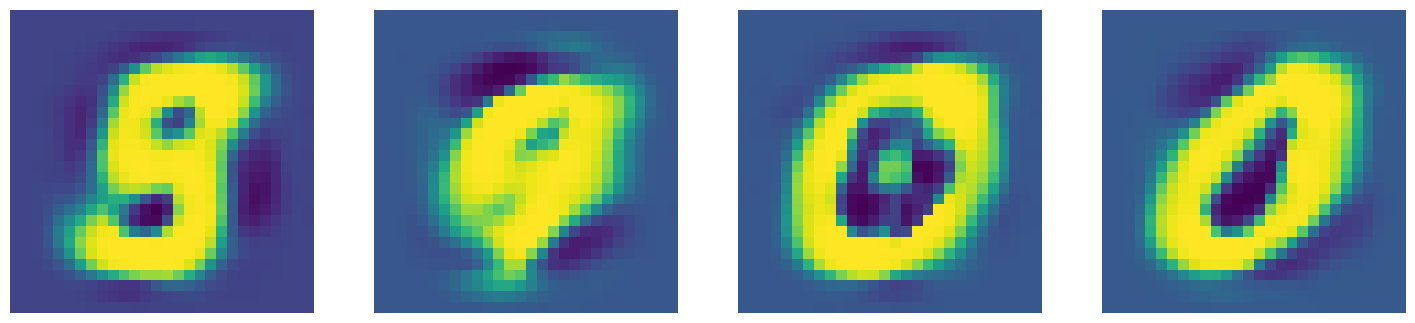

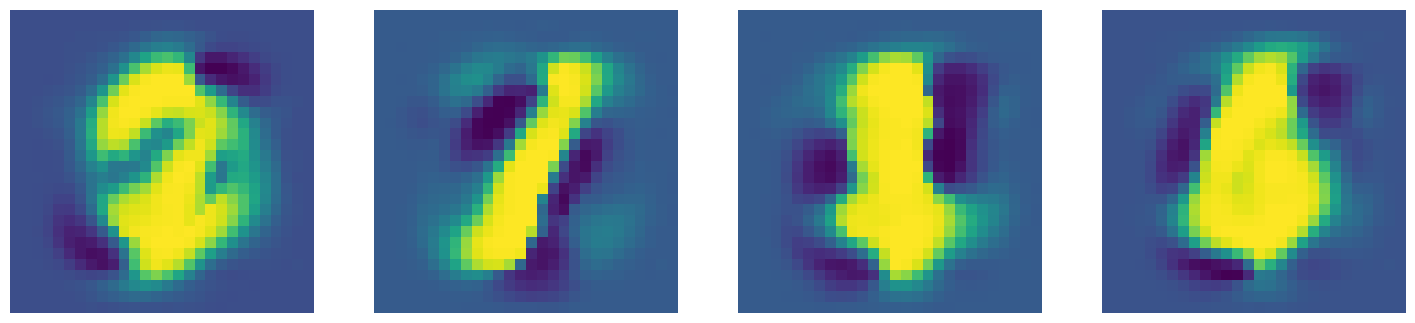

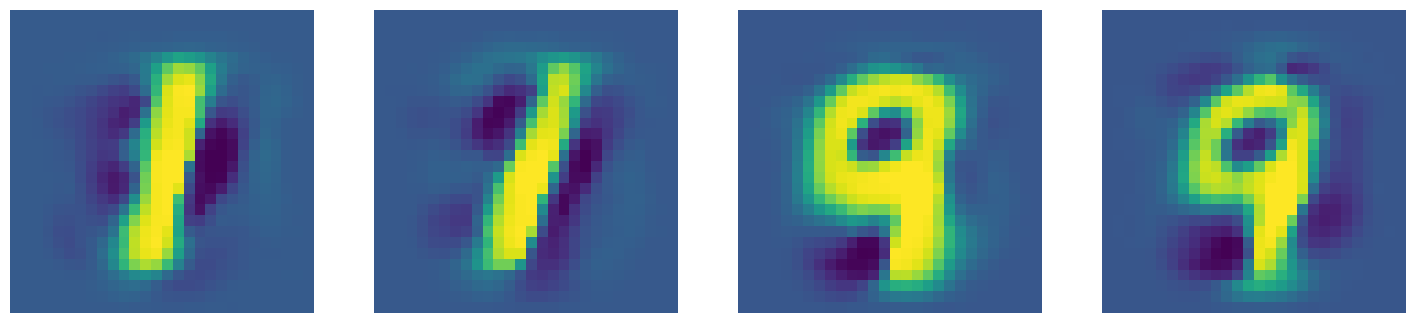

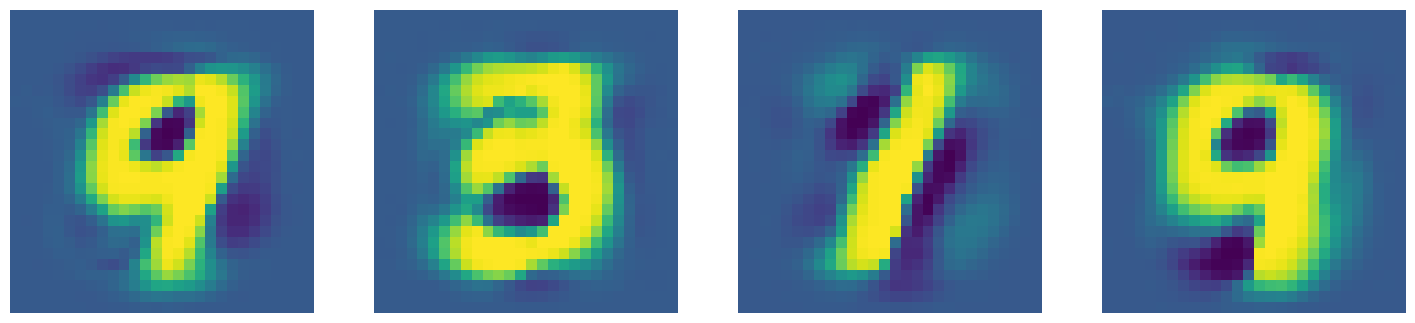

In [30]:
num_epochs = 20
# do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        # noise = do(torch.ones(img.shape)).to(device)
        # img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(None, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

# Производные по входам + DeepDream для нашего модельного случая

In [ ]:
for name, param in model_cnn.named_parameters():
    if ("bn" not in name):
        param.requires_grad = False

In [ ]:
x = torch.randn(1, 1, 28, 28, device=device, requires_grad=True)

In [ ]:
class myDD(nn.Module):
    """
    делаем модель, у которой параметры - входное изображение
    """
    def __init__(self, model, x):
        super().__init__()
        self.weights = nn.Parameter(x)
        self.model = model
        # self.do = nn.Dropout2d(0.5)

    def forward(self):
        return self.model(self.weights)

model = myDD(model_cnn, x)

In [ ]:
def trainx(nepoch, model, class2learn=0):
    """
    - сколько эпох
    - какая модель
    - на какой класс
    """
    images = []
    target = torch.tensor([class2learn]).to(device) #torch.tensor([1,0,0,0,0,0,0,0,0,0]).unsqueeze(0).to(device)

    # ядро для сглаживания
    cnv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (3,3), stride = 1, padding=1).to(device)
    cnv.weight.data = cnv.weight.data*0 + (1.0/9.0)
    cnv.bias[0] = 0.0

    for i in range(nepoch):
        model.train()
        optimizer.zero_grad()
        output = model()
        #print(output.shape, target.shape)
        loss = F.nll_loss(output, target)

        loss.backward()
        optimizer.step()
        if i % 100 == 25:
            # сглаживаем
            model.weights.data = cnv(model.weights.data)

        if i % 100 == 0:
            print(f'i={i} loss={loss}')
            images.append(model.weights.squeeze().detach().cpu())
    return images

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
images = trainx(1000, model, class2learn=0)

i=0 loss=0.7772314548492432
i=100 loss=0.00047588348388671875
i=200 loss=0.00027561187744140625
i=300 loss=0.0002117156982421875
i=400 loss=0.000156402587890625
i=500 loss=0.000125885009765625
i=600 loss=0.00010585784912109375
i=700 loss=9.250640869140625e-05
i=800 loss=8.296966552734375e-05
i=900 loss=7.534027099609375e-05


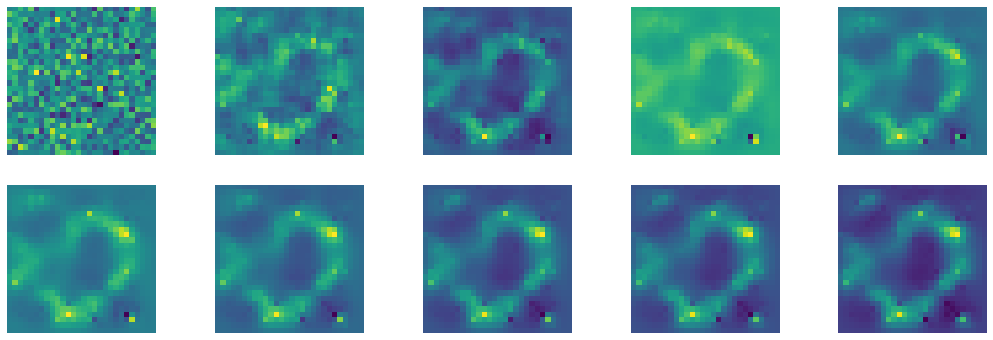

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(images[i])
    # (f'i = {i*100}')
    plt.axis('off')

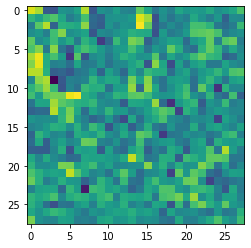

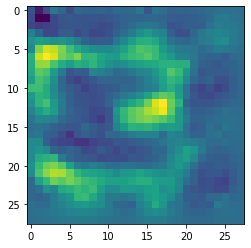

In [ ]:
plt.imshow(x.squeeze().detach().cpu())
plt.show()
plt.imshow(model.weights.squeeze().detach().cpu())

i=0 loss=0.00019741058349609375
i=100 loss=0.0001697540283203125
i=200 loss=0.00014209747314453125
i=300 loss=0.0001316070556640625
i=400 loss=0.0001201629638671875
i=500 loss=0.000110626220703125
i=600 loss=0.0001010894775390625
i=700 loss=8.487701416015625e-05
i=800 loss=8.106231689453125e-05
i=900 loss=7.2479248046875e-05


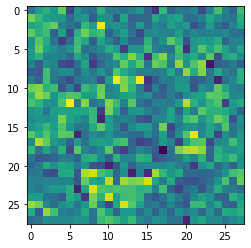

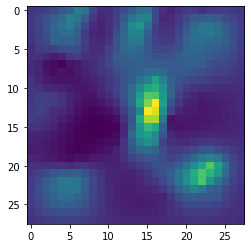

In [ ]:
trainx(1000, model, class2learn=1)
plt.imshow(x.squeeze().detach().cpu())
plt.show()
plt.imshow(model.weights.squeeze().detach().cpu())